# Classifying Fashion-MNIST

We'll be using the Fashion-MNIST dataset, a drop-in replacement for the MNIST dataset. Fashion-MNIST is a set of 28x28 greyscale images of clothes. It's more complex than MNIST, so it's a better representation of the actual performance of network, and a better representation of datasets you'll use in the real world.

## Importing Dependices
First off, let's import the important dependices like NumPy, Matplotlb, Torch Torchvision.

In [ ]:
import sys

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim

from torchvision import datasets, transforms

%matplotlib inline

## Loading Dataset

We need to get our dataset. This is provided through the torchvision package. The code below will download the FashionMNIST dataset, then create training and test datasets for us.

In [2]:
seed = torch.initial_seed()
HUMAN_LABELS = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)), ])

trainset = datasets.FashionMNIST(root="~/.pytorch/FashionMNIST_data", train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True)

testset = datasets.FashionMNIST(root="~/.pytorch/FashionMNIST_data", train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=True)

## Visualizing Dataset

You'll notice I created the trainloader with a batch size of 256, and shuffle=True. The batch size is the number of images we get in one iteration from the data loader and pass through our network, often called a batch. And shuffle=True tells it to shuffle the dataset every time we start going through the data loader again. But here I'm just grabbing the first batch so we can check out the data. In below code images is just a tensor with size (256, 1, 28, 28). So, 256 images per batch, 1 color channel, and 28x28 images. Lets us visualize images below.

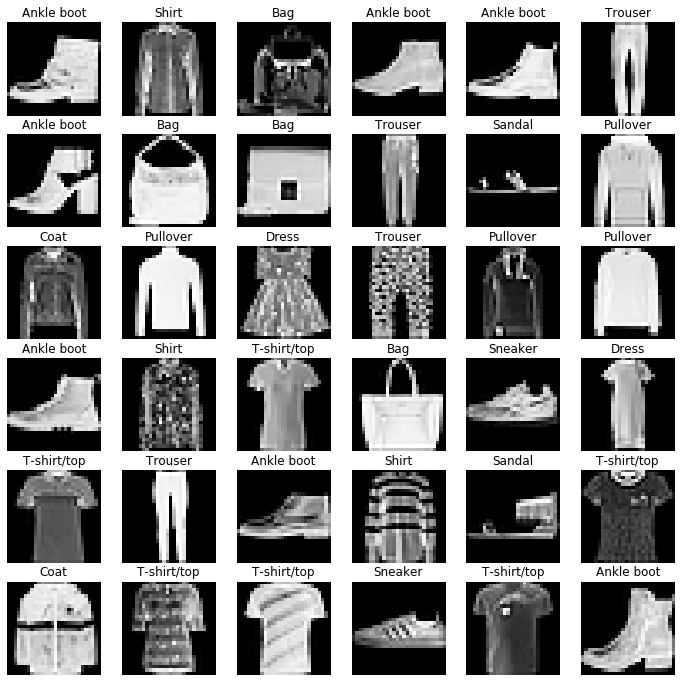

In [3]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

fig, ax = plt.subplots(6, 6, figsize=(12, 12))  
for i in range(len(ax)): 
    for j in range(len(ax[i])):
        ax[i,j].imshow(images[i * 6 + j].numpy().squeeze(), cmap='Greys_r')
        ax[i,j].set_title(HUMAN_LABELS[labels[ i * 6 + j].numpy()])
        ax[i,j].axis('off')

## Helper Functions

In [4]:
def progressBar(e, te, c, t, loss, accuracy):
    cp = c * 50 / t
    sys.stdout.flush()
    sys.stdout.write('\r')
    sys.stdout.write("Epoch [%3d/%3d] [%s%s] %3.2f %% " % (e, te, '*' * int(cp), '.'*(50 - int(cp)), cp*2))
    sys.stdout.write(" Loss: {:.3f}, Accuracy: {:.3f}".format(loss, accuracy))

## Building Network(Alexnet)

AlexNet famously won the 2012 ImageNet LSVRC-2012 competition by a large margin (15.3% VS 26.2% (second place) error rates).

### The highlights of the paper
- Use Relu instead of Tanh to add non-linearity. It accelerates the speed by 6 times at the same accuracy.
- Use dropout instead of regularisation to deal with overfitting. However the training time is doubled with the dropout rate of 0.5.
- Overlap pooling to reduce the size of network. It reduces the top-1 and top-5 error rates by 0.4% and 0.3%, repectively.

### The architecture
It contains 5 convolutional layers and 3 fully connected layers. Relu is applied after very convolutional and fully connected layer. Dropout is applied before the first and the second fully connected year. The image size in the following architecutre chart should be 227 * 227 instead of 224 * 224, as it is pointed out by Andrei Karpathy in his famous CS231n Course.

![orignal_architech.png](./images/original_architecture.png)

### Model Architecture
<div style="display:inline-block; width: 50%;" >

The entire model consists of 14 layers in total. In addition to layers below lists what techniques are applied to build the model.
- **Layer 1**
    - Convolution with 96 different filters in size of (3x3) and stride of 2 with padding same
    - ReLU activation function
    - Max Pooling by 3 and stride of 2
    - Local Response Normalization
- **Layer 2**
    - Convolution with 256 different filters in size of (3x3) and stride of 2 with padding same
    - ReLU activation function
    - Max Pooling by 3 and stride of 2
    - Local Response Normalization
- **Layer 3**
    - Convolution with 384 different filters in size of (3x3) and stride of 1 with padding same
    - ReLU activation function
- **Layer 4**
    - Convolution with 384 different filters in size of (3x3) and stride of 1 with padding same
    - ReLU activation function
- **Layer 5**
    - Convolution with 256 different filters in size of (3x3) and stride of 1 with padding same
    - ReLU activation function
    - Max Pooling by 3 and stride of 2
- **Flattening the 3-D output of the last convolving operations.**
- **Fully Connected Layer with 512 units**
    - ReLU activation function
    - Dropout
- **Fully Connected Layer with 256 units**
    - ReLU activation function
    - Dropout
- **Fully Connected Layer with 10 units (number of image classes)**
</div>


In [5]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        # first conv layer, downsampling layer, and normalization layer
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=96, kernel_size=3, stride=2, padding=1, dilation=1),
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=3, stride=2, padding=1, dilation=1),
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d( kernel_size=3, stride=2, padding=1)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=2, padding=1, dilation=1),
            nn.ReLU()
        )
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=2, dilation=1),
            nn.ReLU()
        )
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=2, dilation=1),
            nn.ReLU(),
            nn.MaxPool2d( kernel_size=3, stride=2)
        )
        
        self.fc_layer_1 = nn.Sequential(
            nn.Linear(in_features=(256 * 2 * 2), out_features=512),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=True),
        )
        
        self.fc_layer_2 = nn.Sequential(
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=True)
        )
        
        self.output_layer = nn.Sequential(
            nn.Linear(in_features=256, out_features=10),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(-1, 256 * 2 * 2)  # reduce the dimensions for linear layer input
        x = self.fc_layer_1(x)
        x = self.fc_layer_2(x)
        return self.output_layer(x)

In [6]:
model = Model()
model.cuda()
print(model)

Model(
  (layer1): Sequential(
    (0): Conv2d(1, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
  )
  (layer5): Sequential(
    (0): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer_1): Sequ

## Training Neural Networks


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=0.001)
start_epoch = 0
total_epoch = 10
accuracies = []
losses = []

### Loading Checkpoint for continue trainings

In [8]:
# # Load checkpoint uncomment code
# checkpoint = torch.load('fashion_mnsit_model.pth')

# model.load_state_dict(checkpoint['state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer'])
# start_epoch = checkpoint['epoch']
# seed = checkpoint['seed']
# accuracies = checkpoint['accuracy']
# losses = checkpoint['loss']

In [9]:
print('Starting training...')
for epoch in range(start_epoch, total_epoch + 1):
    train_loss = 0.0
    train_accuracy = 0.0
    batch = 0
    losses.append(0.0)
    accuracies.append(0.0)
    
    for images, labels in trainloader:
        # Loading Mnsit to GPU
        images = images.cuda()
        labels = labels.cuda()
        
        # zeroes the gradient buffers of all parameters
        optimizer.zero_grad()
        
        # forward + backward + optimize
        output = model(images) # forward
        loss = criterion(output, labels) # calculate the loss
        loss.backward() # back propagation
        optimizer.step()  # update gradients
        
        # Loss + Accuracy 
        train_loss += loss.item()
        train_accuracy += (torch.argmax(output, dim = 1) == labels).float().sum()
        
        progressBar(epoch, total_epoch, batch, len(trainloader), losses[epoch - 1], accuracies[epoch-1])        
        batch += 1

    losses[epoch] = train_loss / len(trainloader)
    accuracies[epoch] = train_accuracy * 100 / len(trainset)
    
    progressBar(epoch, total_epoch, len(trainloader), len(trainloader), losses[epoch], accuracies[epoch])
    
    if(epoch % 10 == 0):
        state = {'epoch': epoch,'state_dict': model.state_dict(),'optimizer': optimizer.state_dict(),
                 'seed': seed, 'accuracy': accuracies, 'loss': losses }
        torch.save(state, "fashion_mnsit_model.pth")

Starting training...


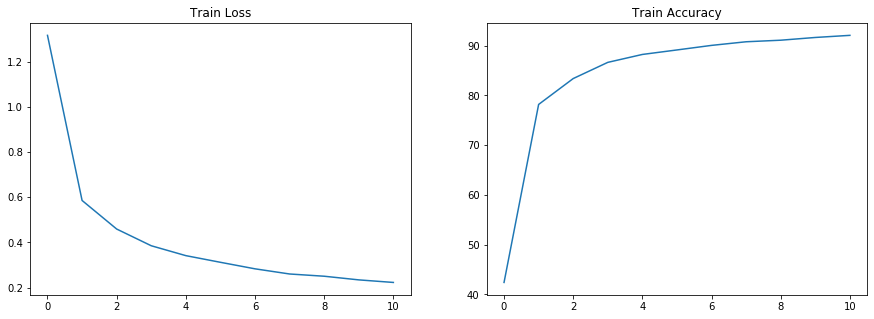

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_title('Train Loss')
ax[1].set_title('Train Accuracy')
ax[0].plot(losses)
ax[1].plot(accuracies)

In [13]:
# Test
model.eval()
test_loss = 0.0
test_accuracy = 0.0

for images, labels in testloader:
    # Loading Mnsit to GPU
    images = images.cuda()
    labels = labels.cuda()

    # zeroes the gradient buffers of all parameters
    optimizer.zero_grad()

    # forward + backward + optimize
    output = model(images) # forward
    loss = criterion(output, labels) # calculate the loss
    
    # Loss + Accuracy 
    test_loss += loss.item()
    test_accuracy += (torch.argmax(output, dim = 1) == labels).float().sum()


print("Test Loss: {} Test Accuracy: {}".format(test_loss / len(testloader), test_accuracy * 100 / len(testset)))

Test Loss: 0.31397608332335947 Test Accuracy: 89.68000030517578


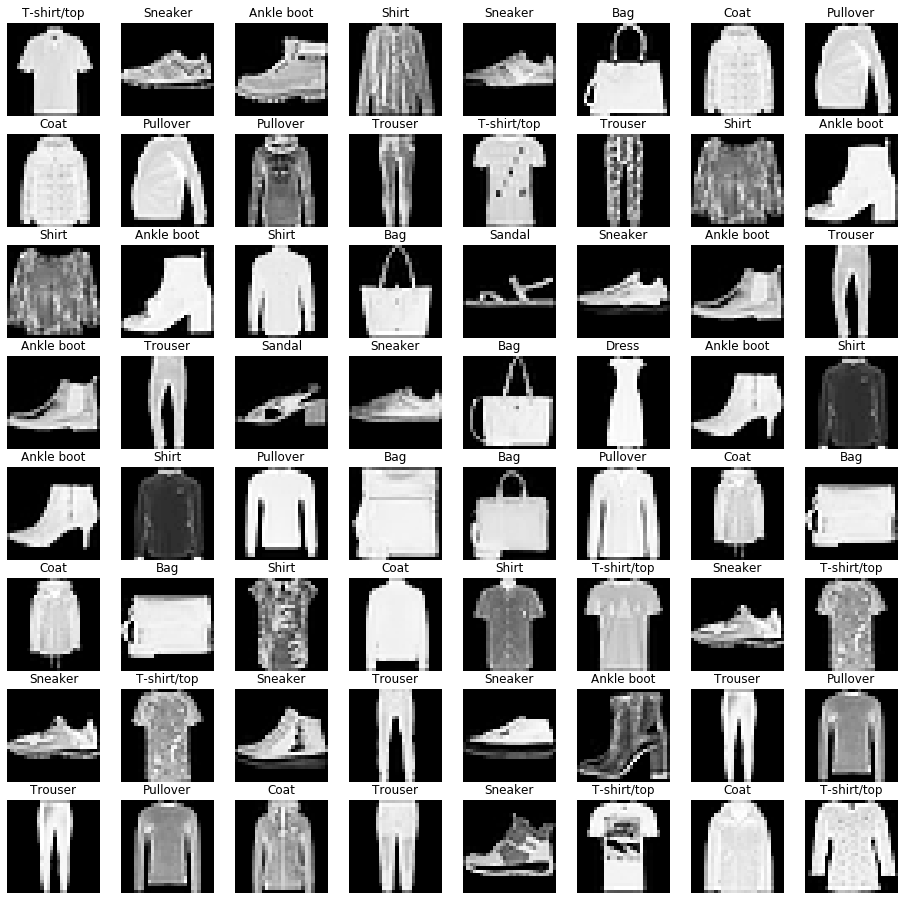

In [14]:
# Inference

model.eval()

testiter = iter(testloader)
images, _ = testiter.next()
output = model(images.cuda())
predictions = torch.argmax(output, dim = 1)

fig, ax = plt.subplots(8, 8, figsize=(16, 16))  
for i in range(len(ax)): 
    for j in range(len(ax[i])):
        ax[i,j].imshow(images[i * 6 + j].numpy().squeeze(), cmap='Greys_r')
        ax[i,j].set_title(HUMAN_LABELS[predictions[i * 6 + j]])
        ax[i,j].axis('off')